#  importing libaries and making connection to databse 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [42]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "abdul123",
                            database = "ecommerce")

cur = db.cursor()

#  List all unique cities where customers are located.

In [43]:
query = """select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  Count the number of order placed in 2017.

In [44]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()
"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 90202)

#  Find the total sales per category.

In [45]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


#  Calculate the percentage of orders that were paid in installments.

In [46]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments 
"""

cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

#  Count the number of customers from each state.

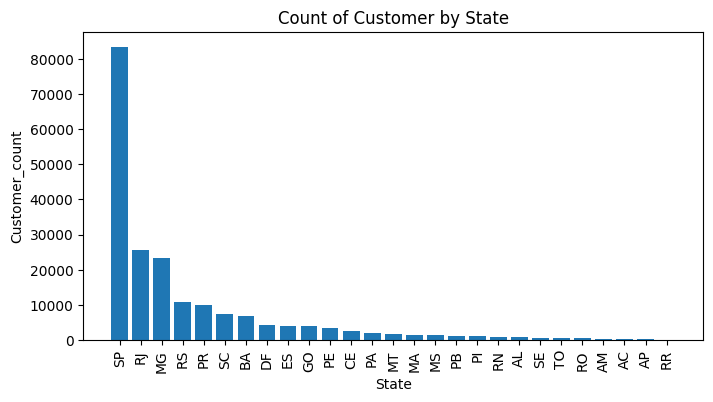

In [47]:
query = """ select customer_state, count(customer_id) 
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,4))
plt.bar(df["state"], df["customer_count"])

plt.xlabel("State")
plt.ylabel("Customer_count")
plt.title("Count of Customer by State")
plt.xticks(rotation = 90)

plt.show()

#  Calculate the number of orders per month in 2018.

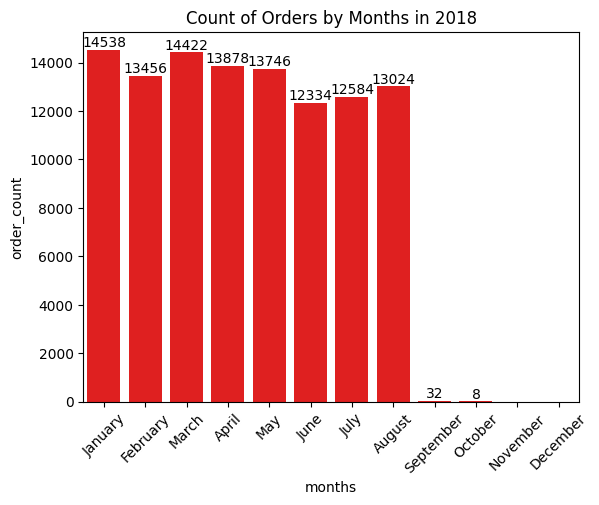

In [48]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) 
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ['January','February','March','April','May','June','July','August','September','October','November','December']

ax = sns.barplot(x = df['months'], y = df['order_count'], order = o, color = 'red')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

#  Find the average number of products per order, gouped by city.

In [49]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, 
count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['City','Average_order'])
df.head(10)

,City,Average_order
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


#  Calculate the percentage of tatal revenue contributed by each product category.

In [50]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) 
sales from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category','Percentage distribution'])
df.head(10)

,Category,Percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


#  Identify the correlation between product price and the number of times a product has been purchased.

In [51]:
query = """ select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category 
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Products_Category','order_count','price'])
df.head(10)
arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef([arr1,arr2])
print("The correlation is", a[0][-1])

The correlation is -0.1039084991525169


#  Calculate the total revenue generated by each seller, and rank them by revenue.

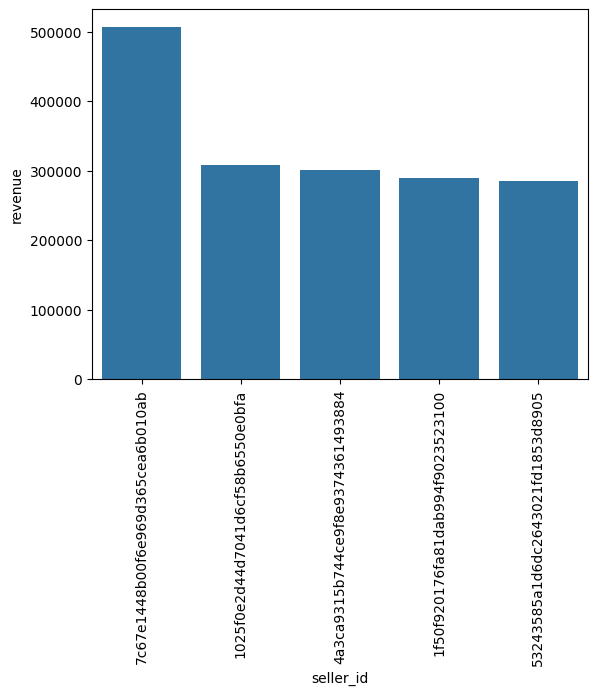

In [52]:
query = """ select * , rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

#  Calculate the moving average of order values for each customer over their order history.

In [57]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id", "History", "Payment", "Mov_Avg"])
df.head(10)

,Customer_id,History,Payment,Mov_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
7,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
8,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
9,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


#  Calculate the cumulative sales per month for each year.

,Years,Months,payments,Cumulative_sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


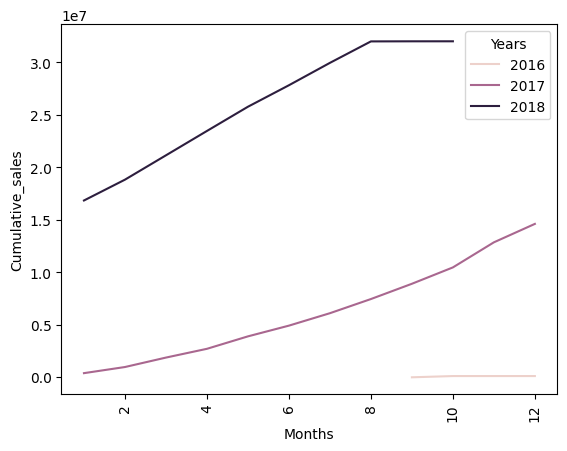

In [103]:
query = """ select years,months,payment, sum(payment)
over (order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years)as a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Years","Months","payments","Cumulative_sales"])
sns.lineplot(data = df, x = "Months", y = "Cumulative_sales" , hue = "Years")
plt.xticks(rotation = 90)
df.head(10)

#  Calculate the year-over-year growth rate of total sales.

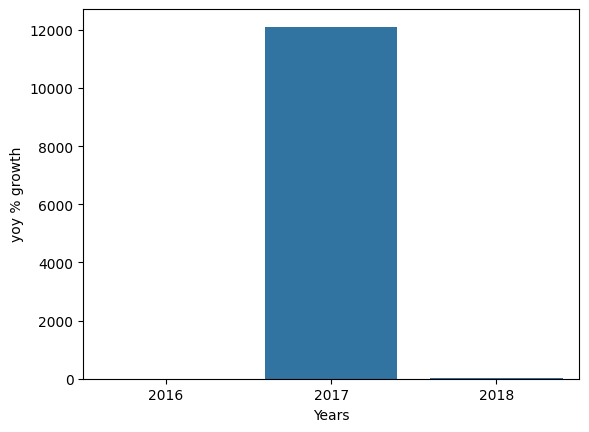

In [84]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, round(((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 , 2) from a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "yoy % growth"])
df
sns.barplot(data = df, x = "Years" , y = "yoy % growth" )
plt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [ ]:
query = """ with a as (select customers.customer_id, 
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""

cur.execute(query)

data = cur.fetchall()
data

# since none of our customer is repeated therefore the value is None

#  Identify the top 3 customers who spent the most money in each year.

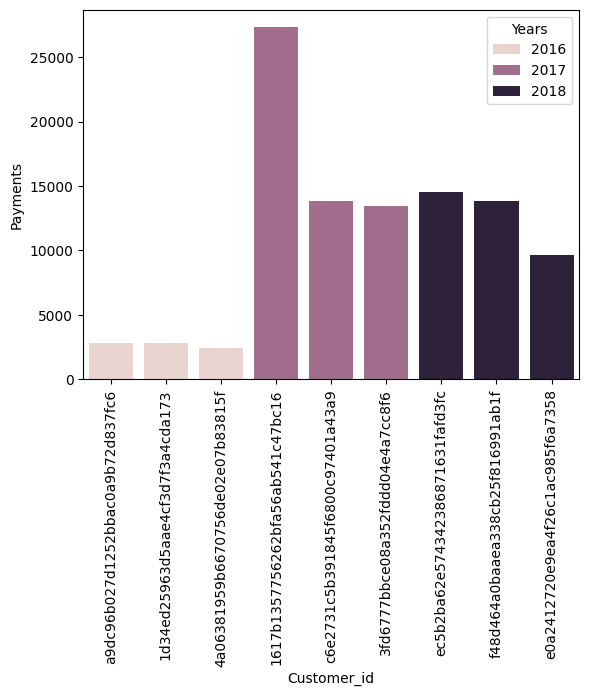

In [102]:
query = """ 
select years, customer_id, payment, d_rank 
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over( partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years','Customer_id','Payments','Rank'])
sns.barplot(data = df,
            x = 'Customer_id',
            y = 'Payments',
            hue = 'Years')

plt.xticks(rotation = 90)
plt.show()